In [59]:
import function_list as ff
import os
import numpy as np
import nibabel as nib 
import math
from scipy import misc
import matplotlib.pyplot as plt
from PIL import Image
import cv2
print('ok')

ok


In [60]:
base_dir = '/Volumes/McVeighLab/projects/Zhennong/AI/CNN/all-classes-all-phases-1.5'
patient_list = ff.find_all_target_files(['ucsd_toshiba/000'],base_dir)

In [147]:
# load plane information
for patient in patient_list:
    patient_id = os.path.basename(patient)
    patient_class = os.path.basename(os.path.dirname(patient))
    print(patient_class,patient_id)


    mpr_planes = nib.load(os.path.join(patient,'mpr-new-nii-sm-1.5/2C/0.nii.gz')) 
    mpr_data = mpr_planes.get_fdata()
    
    seg = nib.load(os.path.join(patient,'seg-nii-sm/0.nii.gz')); seg_data = seg.get_fdata()
    volume = nib.load(os.path.join(patient,'img-nii-sm/0.nii.gz')); volume_data = volume.get_fdata()
    
    # ground truth vectors
    vector_4C = ff.get_ground_truth_vectors(patient,'4C_MR.npy')
    vector_SA = ff.get_ground_truth_vectors(patient,'BASAL_MR.npy')
    image_center = vector_SA['img_center']
    
    # get a list of center points of SA stack, the orientation keeps constant
    n = ff.normalize(np.cross(vector_SA['x'],vector_SA['y']))
    ahead,behind = ff.find_num_of_slices_in_SAX(mpr_data,image_center,vector_SA['t'],vector_SA['x'],vector_SA['y'],seg_data,8)
    center_list = ff.find_center_list_whole_stack_upsampled(image_center+vector_SA['t'],n,ahead,behind,1.5,default_thickness = 8)
    
    # get affine matrix
    volume_affine = ff.check_affine(os.path.join(patient,'img-nii-sm/0.nii.gz'))
    A_4C_gt = ff.get_affine_from_vectors(mpr_data,volume_affine,vector_4C)

ucsd_toshiba 000


In [62]:
save_path = '/Volumes/McVeighLab/projects/Zhennong/Video Prediction/Test_Data/LV'

In [ ]:
inter = ff.define_interpolation(volume_data,Fill_value=volume_data.min(),Method='linear')
mpr_shape = mpr_data.shape
sa_stack = np.zeros((mpr_shape[0],mpr_shape[1],center_list.shape[0]))

for i in range(0,center_list.shape[0]):
    sa_raw = ff.reslice_mpr(mpr_data,center_list[i],vector_SA['x'],vector_SA['y'],1,1,inter)
    sa_stack[:,:,i] = sa_raw[:,:,0]
    
    sa = ff.set_window(sa_raw,500,900)
    # save as image
    ii = np.zeros((mpr_shape[0],mpr_shape[1],3))
    ii[0:mpr_shape[0],0:mpr_shape[1],0] = sa.T
    ii[0:mpr_shape[0],0:mpr_shape[1],1] = sa.T
    ii[0:mpr_shape[0],0:mpr_shape[1],2] = sa.T
    
    #Image.fromarray((ii * 255).astype('uint8')).save(os.path.join(save_path,str(i)+'.png'))
    
print(sa_stack.shape)                                                   

In [63]:
pngs = ff.sort_timeframe(ff.find_all_target_files(['*.png'],save_path),1)

make_movies(os.path.join(save_path,patient_class+'_'+patient_id+'_SAX.avi'),pngs)

## Rotate the image to show particular wall

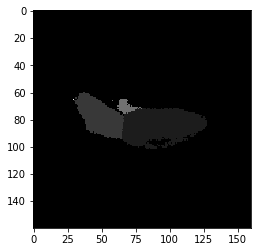

In [207]:
# now try to rotate the stack so that a particular wall is in 6 o'clock
inter = ff.define_interpolation(seg_data,Fill_value=seg_data.min(),Method='nearest')
fourc = ff.reslice_mpr(mpr_data,vector_4C['t'] + image_center,vector_4C['x'],vector_4C['y'],1,1,inter)
ii = int(sa_stack.shape[-1] / 2)
sa_slice = ff.reslice_mpr(mpr_data,center_list[ii],vector_SA['x'],vector_SA['y'],1,1,inter)
A_sa_slice = ff.get_affine_from_vectors(mpr_data,volume_affine,ff.sa_affine(center_list[ii],image_center,vector_SA))
plt.imshow(fourc[:,:,0],cmap='gray')

In [208]:
# find the intersection between lax and sax
_,intersect_direct,intersect_point = ff.draw_plane_intersection(fourc,vector_SA['x'],vector_SA['y'],A_sa_slice,A_4C_gt,volume_affine)
intersect_direct = ff.normalize(intersect_direct)
print(intersect_direct)

# in case that the intersect_direct is in wrong side of wall but far away from LV
count,p_LV = ff.count_pixel(fourc,1)
cg = np.sum(p_LV,axis = 0)/count

# find a point in inferoseptal wall, which we know is in negative x direction of cg 
direction = -1 # -1 if negative x direction, 1 is positive

if np.sign(direction) == np.sign(intersect_direct[0]):
    increment_sign = 1
else:
    increment_sign = -1

i = 1
while(1):
    point = intersect_point + intersect_direct * increment_sign * i
    i += 1
    if inter(point) != 1 and np.sign(point[0] - cg[0]) == np.sign(direction):
        wall_point = point + intersect_direct * increment_sign * 5
        break
print(intersect_point,cg, wall_point)

[ 0.99262265 -0.12124473  0.        ]
[ 12.76817526 104.53221542  -0.        ] [84.87772926 93.06113537  0.        ] [  6.81243939 105.25968378  -0.        ]


In [209]:
# find the rotation angle
mpr_center = np.array([(mpr_shape[0]-1)/2,(mpr_shape[1]-1)/2,0])
final_dest_point = np.array([(mpr_shape[0]-1)/2 + 20,(mpr_shape[1]-1)/2,0]) # 6 o'clock in SAX

ii = 30
wall_point_in_sa = ff.convert_coordinates(A_sa,A_4C_gt,wall_point)

rotate_angle = ff.angle(final_dest_point-mpr_center,wall_point_in_sa-mpr_center)
print(rotate_angle)

179.54223226444887


In [210]:
# now try to rotate the image
# define transform matrix
alpha=0 / 180 * math.pi
beta=0 / 180 * math.pi
gamma=rotate_angle / 180 * math.pi # correct one
translation=np.array([[1,0,0,0],
                     [0,1,0,0],
                     [0,0,1,0],
                     [0,0,0,1]])
scale=np.array([[1,0,0,0],
                     [0,1,0,0],
                     [0,0,1,0],
                     [0,0,0,1]])
rotation_by_x=np.array([[1,0,0,0],
                        [0,np.cos(alpha),-np.sin(alpha),0],
                        [0,np.sin(alpha),np.cos(alpha),0],
                        [0,0,0,1]])
rotation_by_y=np.array([[np.cos(beta),0,np.sin(beta),0],
                        [0,1,0,0],
                        [-np.sin(beta),0,np.cos(beta),0],
                        [0,0,0,1]])
rotation_by_z=np.array([[np.cos(gamma),-np.sin(gamma),0,0],
                        [np.sin(gamma),np.cos(gamma),0,0],
                        [0,0,1,0],
                        [0,0,0,1]])
transform_matrix=np.dot(rotation_by_z,np.dot(rotation_by_y,np.dot(rotation_by_x,np.dot(translation,scale))))
#transform_offset_center
def transform_full_matrix_offset_center(matrix, shape):
    shape = np.array([float(s) / 2.0  for s in shape])
    for_mat = np.eye(len(shape) + 1)
    rev_mat = np.eye(len(shape) + 1)
    for_mat[:-1, -1] = +shape
    rev_mat[:-1, -1] = -shape
    return np.dot(np.dot(for_mat, matrix), rev_mat)

transform_matrix_offset=transform_full_matrix_offset_center(transform_matrix,sa_stack.shape)
transform_matrix_offset_cropped=transform_matrix_offset[:-1, :]
final_affine_matrix = transform_matrix_offset_cropped[: sa_stack.ndim, : sa_stack.ndim]
final_offset = transform_matrix_offset_cropped[: sa_stack.ndim, sa_stack.ndim]
print('final_affine_matrix is\n',final_affine_matrix)
print('final_offset is\n',final_offset)

final_affine_matrix is
 [[-0.99996808 -0.00798947  0.        ]
 [ 0.00798947 -0.99996808  0.        ]
 [ 0.          0.          1.        ]]
final_offset is
 [160.63660423 159.35828916   0.        ]


In [211]:
#apply_transform
from scipy.ndimage.interpolation import affine_transform
new_stack=affine_transform(
        sa_stack, final_affine_matrix, final_offset, order=0,mode="constant", cval=sa_stack.min())

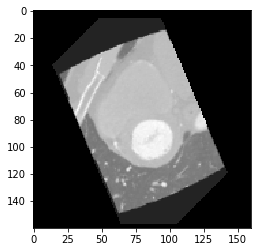

In [215]:
ii = 20
plt.imshow(sa_stack[:,:,ii],cmap='gray')

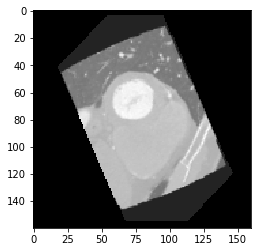

In [216]:
plt.imshow(new_stack[:,:,ii],cmap='gray')